In [1]:
import geopandas as gpd
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import numpy as np
import statsmodels.api as sm

In [2]:
# Загрузим актуальные границы МО и присоеденим к ним названия
gdf_t_dict_municipal_districts_poly = gpd.read_file("../data/sberindex/6_t_dict_municipal/t_dict_municipal_districts_poly.gpkg")
gdf_t_dict_municipal_districts_poly["territory_id"] = gdf_t_dict_municipal_districts_poly["territory_id"].astype(int)
gdf_t_dict_municipal_districts_poly = gdf_t_dict_municipal_districts_poly[gdf_t_dict_municipal_districts_poly["year_to"] == 9999]

df_t_dict_municipal_districts = pd.read_excel("../data/sberindex/6_t_dict_municipal/t_dict_municipal_districts.xlsx")
df_t_dict_municipal_districts = df_t_dict_municipal_districts[df_t_dict_municipal_districts["year_to"] == 9999]
df_t_dict_municipal_districts = df_t_dict_municipal_districts[
    ["territory_id", "municipal_district_name_short", "municipal_district_name", "region_name"]
]

gdf_t_dict_municipal_districts_poly = gdf_t_dict_municipal_districts_poly.merge(
    df_t_dict_municipal_districts, on="territory_id", how="left"
)

# Блок с анализом зарплат

In [27]:
# Сформируем среднюю зарплату по МО по всем отраслям в 2024 году
df_4_bdmo_salary = pd.read_parquet("../data/sberindex/4_bdmo_salary.parquet")
df_salary_for_2023_2024 = df_4_bdmo_salary[(df_4_bdmo_salary["okved_name"] == "Все отрасли")]
df_salary_for_2023_2024 = df_salary_for_2023_2024.groupby("territory_id").agg({"value": "mean"}).reset_index()
df_salary_for_2023_2024.rename(columns={"value": "mean_salary_for_2023_2024"}, inplace=True)
df_salary_for_2023_2024

,territory_id,mean_salary_for_2023_2024
0,1,49981.4750
1,2,40875.8625
2,3,48455.1875
3,4,45499.9125
4,5,43428.8125
...,...,...
2604,3011,56620.6875
2605,3012,50391.6625
2606,3013,41369.8750
2607,3014,88593.4000


In [ ]:
# Присоеденим к средние зарплаты к геометриям МО
gdf_salary_for_2023_2024 = gdf_t_dict_municipal_districts_poly.merge(df_salary_for_2023_2024, on="territory_id", how="left")
gdf_salary_for_2023_2024.to_file("salary_for_2023_2024.gpkg", driver="GPKG")
gdf_md_with_salary_for_2023_2024 = gdf_salary_for_2023_2024[gdf_salary_for_2023_2024["mean_salary_for_2023_2024"].notna()]
gdf_md_without_salary_for_2023_2024 = gdf_salary_for_2023_2024[gdf_salary_for_2023_2024["mean_salary_for_2023_2024"].isna()]

# Отсеем Москву, так как она сильно отрывается от остальных
print("В какие субъекты входят топ-50 МО с наивысшей зарплатой:")
print(gdf_md_with_salary_for_2023_2024.sort_values("mean_salary_for_2023_2024", ascending=False).iloc[0:50]["region_name"].value_counts())
gdf_md_with_salary_for_2023_2024_without_msk = gdf_md_with_salary_for_2023_2024[
    ~gdf_md_with_salary_for_2023_2024["region_name"].isin(["Москва"])
]

В какие субъекты входят топ-50 МО с наивысшей зарплатой:
region_name
Москва                             31
Ямало-Ненецкий автономный округ     4
Чукотский автономный округ          3
Камчатский край                     3
Санкт-Петербург                     2
Магаданская область                 2
Сахалинская область                 2
Амурская область                    1
Красноярский край                   1
Республика Саха (Якутия)            1
Name: count, dtype: int64


In [29]:
# m = gdf_md_with_salary_for_2023_2024.explore(column="salary_all_2024", cmap="Spectral")
# gdf_md_without_salary_for_2023_2024.explore(m=m, color="grey")
# m

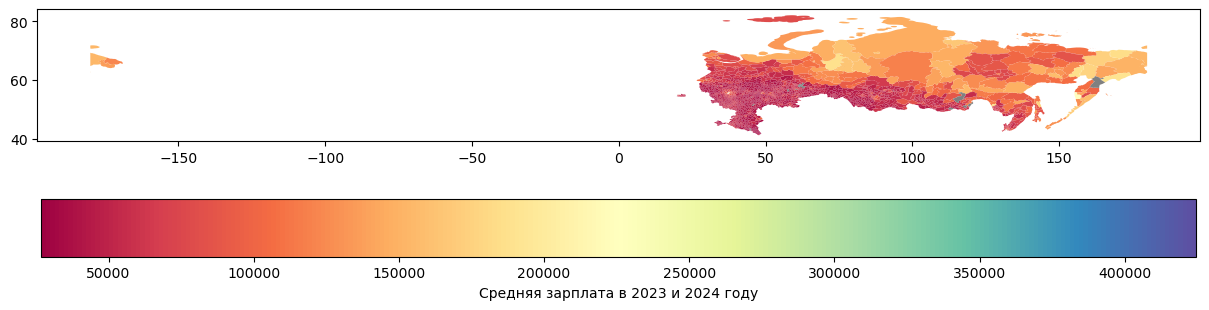

In [30]:
fig, ax = plt.subplots(1, 1, figsize=(15, 5))
plot = gdf_md_with_salary_for_2023_2024_without_msk.plot(
    column='mean_salary_for_2023_2024', 
    cmap='Spectral', 
    ax=ax,
    legend=True,
    legend_kwds={
        'label': 'Средняя зарплата в 2023 и 2024 году',
        'orientation': 'horizontal'
    },
    aspect='equal'
)
gdf_md_without_salary_for_2023_2024.plot(color='grey', ax=ax, aspect='equal')
plt.show()

In [31]:
# Составим пары соседних МО
gdf_md_for_neighbors_salary = gdf_md_with_salary_for_2023_2024_without_msk[["geometry", "territory_id", "mean_salary_for_2023_2024"]].copy()
gdf_md_for_neighbors_salary.sindex

df_md_neighbors_salary = gpd.sjoin(gdf_md_for_neighbors_salary, gdf_md_for_neighbors_salary, how="inner", predicate="touches")
df_md_neighbors_salary = df_md_neighbors_salary[df_md_neighbors_salary["territory_id_left"] != df_md_neighbors_salary["territory_id_right"]]
df_md_neighbors_salary = df_md_neighbors_salary[["territory_id_left", "mean_salary_for_2023_2024_left", "territory_id_right", "mean_salary_for_2023_2024_right"]]

# Избавимся от повторных пересечений
df_md_neighbors_salary['pair_min'] = df_md_neighbors_salary[['territory_id_left', 'territory_id_right']].min(axis=1)
df_md_neighbors_salary['pair_max'] = df_md_neighbors_salary[['territory_id_left', 'territory_id_right']].max(axis=1)
df_md_neighbors_salary = df_md_neighbors_salary.drop_duplicates(subset=['pair_min', 'pair_max'])
df_md_neighbors_salary = df_md_neighbors_salary.drop(columns=['pair_min', 'pair_max'])

# Определим разницу в зарплатах между соседними МО
df_md_neighbors_salary["salary_difference"] = abs(df_md_neighbors_salary["mean_salary_for_2023_2024_right"] - df_md_neighbors_salary["mean_salary_for_2023_2024_left"])

In [32]:
# Топ-10 пар соседних МО с наибольшей разницей в зарплатах
df_top10_differences_of_salary = df_md_neighbors_salary.sort_values("salary_difference", ascending=False).iloc[0:10].copy()
df_top10_differences_of_salary

,territory_id_left,mean_salary_for_2023_2024_left,territory_id_right,mean_salary_for_2023_2024_right,salary_difference
2304,2371,424601.3500,2412,95977.1875,328624.1625
2300,2370,98087.0750,2371,424601.3500,326514.2750
2301,2377,105895.7250,2371,424601.3500,318705.6250
2304,2371,424601.3500,2372,114706.9500,309894.4000
2304,2371,424601.3500,2376,118018.0875,306583.2625
1325,614,225355.1375,613,78409.7625,146945.3750
1350,883,185512.9625,885,56335.9625,129177.0000
1349,879,56821.4625,883,185512.9625,128691.5000
1324,621,107578.8250,614,225355.1375,117776.3125
1350,883,185512.9625,872,67839.6000,117673.3625


In [9]:
# Добавим геометрию для пар
gdf_md_for_neighbors_salary_only_geometry = gdf_md_for_neighbors_salary[["geometry", "territory_id"]].copy()

gdf_top10_differences_of_salary = df_top10_differences_of_salary.merge(
    gdf_md_for_neighbors_salary_only_geometry[["territory_id", "geometry"]], left_on="territory_id_left", right_on="territory_id", how="left"
)
gdf_top10_differences_of_salary.drop(columns=["territory_id"], inplace=True)
gdf_top10_differences_of_salary.rename(columns={"geometry": "geometry_left"}, inplace=True)

gdf_top10_differences_of_salary = gdf_top10_differences_of_salary.merge(
    gdf_md_for_neighbors_salary_only_geometry[["territory_id", "geometry"]], left_on="territory_id_right", right_on="territory_id", how="left"
)
gdf_top10_differences_of_salary.drop(columns=["territory_id"], inplace=True)
gdf_top10_differences_of_salary.rename(columns={"geometry": "geometry_right"}, inplace=True)

gdf_top10_differences_of_salary = gpd.GeoDataFrame(gdf_top10_differences_of_salary, geometry="geometry_left")

# Отобразим полученный топ-10
gdf1_salary = gdf_top10_differences_of_salary.set_geometry("geometry_left")
gdf1_salary = gdf1_salary[["geometry_left", "territory_id_left", "mean_salary_for_2023_2024_left", "salary_difference"]]
gdf1_salary.to_file("gdf1_salary.gpkg")
gdf2_salary = gdf_top10_differences_of_salary.set_geometry("geometry_right")
gdf2_salary = gdf2_salary[["geometry_right", "territory_id_right", "mean_salary_for_2023_2024_right", "salary_difference"]]
gdf2_salary.to_file("gdf2_salary.gpkg")

# Отображаем с общей шкалой
vmin = min(gdf1_salary["mean_salary_for_2023_2024_left"].min(), gdf2_salary["mean_salary_for_2023_2024_right"].min())
vmax = max(gdf1_salary["mean_salary_for_2023_2024_left"].max(), gdf2_salary["mean_salary_for_2023_2024_right"].max())

m = gdf1_salary.explore(column="mean_salary_for_2023_2024_left", cmap="Spectral", vmin=vmin, vmax=vmax, legend=True, legend_kwds={"caption": "Средняя зарплата в 2023 и 2024 году, ₽"})
gdf2_salary.explore(m=m, column="mean_salary_for_2023_2024_right", cmap="Spectral", vmin=vmin, vmax=vmax, legend=False)

# Блок с анализом расходов

<Axes: >

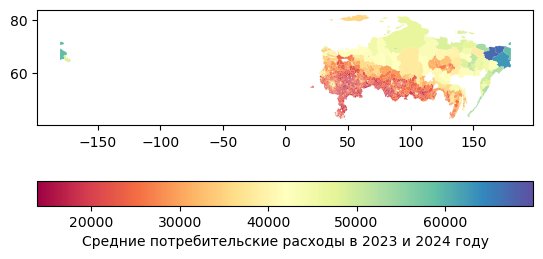

In [10]:
df_8_consumption = pd.read_parquet("../data/sberindex/8_consumption.parquet")
df_8_consumption["year"] = df_8_consumption["date"].str[:4].astype(int)
df_consumption_for_2023_2024 = df_8_consumption[(df_8_consumption["category"] == "Все категории")].copy()
df_consumption_for_2023_2024 = df_consumption_for_2023_2024.groupby(["territory_id"]).agg({"value": "mean"}).reset_index()
df_consumption_for_2023_2024.rename(columns={"value": "mean_spending_for_2023_2024"}, inplace=True)

gdf_md_consumption_for_2023_2024 = gdf_t_dict_municipal_districts_poly.merge(df_consumption_for_2023_2024, on="territory_id", how="left")
gdf_md_consumption_for_2023_2024.plot(
    column='mean_spending_for_2023_2024', 
    cmap='Spectral', 
    legend=True,
    legend_kwds={
        'label': 'Средние потребительские расходы в 2023 и 2024 году',
        'orientation': 'horizontal'
    }
)

In [11]:
# Присоеденим к средние зарпалты к геометриям МО
gdf_consumption_for_2023_2024 = gdf_t_dict_municipal_districts_poly.merge(df_consumption_for_2023_2024, on="territory_id", how="left")
gdf_consumption_for_2023_2024.to_file("consumption_for_2023_2024.gpkg")
gdf_md_with_consumption_for_2023_2024 = gdf_consumption_for_2023_2024[gdf_consumption_for_2023_2024["mean_spending_for_2023_2024"].notna()]
gdf_md_without_consumption_for_2023_2024 = gdf_consumption_for_2023_2024[gdf_consumption_for_2023_2024["mean_spending_for_2023_2024"].isna()]

# Отсеем Москву, так как она сильно отрывается от остальных
print("В какие субъекты входят топ-50 МО с наивысшей зарплатой:")
print(gdf_md_with_consumption_for_2023_2024.sort_values("mean_spending_for_2023_2024", ascending=False).iloc[0:50]["region_name"].value_counts())
gdf_md_with_consumption_for_2023_2024_without_msk = gdf_md_with_consumption_for_2023_2024[
    ~gdf_md_with_consumption_for_2023_2024["region_name"].isin(["Москва"])
]

В какие субъекты входят топ-50 МО с наивысшей зарплатой:
region_name
Москва                             37
Чукотский автономный округ          5
Санкт-Петербург                     2
Сахалинская область                 2
Магаданская область                 1
Камчатский край                     1
Ямало-Ненецкий автономный округ     1
Республика Саха (Якутия)            1
Name: count, dtype: int64


In [12]:
# Составим пары соседних МО
gdf_md_for_neighbors_consumption = gdf_md_with_consumption_for_2023_2024_without_msk[["geometry", "territory_id", "mean_spending_for_2023_2024"]].copy()
gdf_md_for_neighbors_consumption.sindex

df_md_neighbors_consumption = gpd.sjoin(gdf_md_for_neighbors_consumption, gdf_md_for_neighbors_consumption, how="inner", predicate="touches")
df_md_neighbors_consumption = df_md_neighbors_consumption[df_md_neighbors_consumption["territory_id_left"] != df_md_neighbors_consumption["territory_id_right"]]
df_md_neighbors_consumption = df_md_neighbors_consumption[["territory_id_left", "mean_spending_for_2023_2024_left", "territory_id_right", "mean_spending_for_2023_2024_right"]]

# Избавимся от повторных пересечений
df_md_neighbors_consumption['pair_min'] = df_md_neighbors_consumption[['territory_id_left', 'territory_id_right']].min(axis=1)
df_md_neighbors_consumption['pair_max'] = df_md_neighbors_consumption[['territory_id_left', 'territory_id_right']].max(axis=1)
df_md_neighbors_consumption = df_md_neighbors_consumption.drop_duplicates(subset=['pair_min', 'pair_max'])
df_md_neighbors_consumption = df_md_neighbors_consumption.drop(columns=['pair_min', 'pair_max'])

# Определим разницу в зарплатах между соседними МО
df_md_neighbors_consumption["spendings_difference"] = abs(df_md_neighbors_consumption["mean_spending_for_2023_2024_right"] - df_md_neighbors_consumption["mean_spending_for_2023_2024_left"])

In [13]:
# Топ-10 пар соседних МО с наибольшей разницей в расходах
df_top10_differences_of_spendings = df_md_neighbors_consumption.sort_values("spendings_difference", ascending=False).iloc[0:10].copy()
df_top10_differences_of_spendings

,territory_id_left,mean_spending_for_2023_2024_left,territory_id_right,mean_spending_for_2023_2024_right,spendings_difference
1198,2349,67195.166667,335,38884.375000,28310.791667
1198,2349,67195.166667,620,42696.000000,24499.166667
1198,2349,67195.166667,1433,44985.000000,22210.166667
1198,2349,67195.166667,1434,46002.454545,21192.712121
1199,2348,62872.833333,620,42696.000000,20176.833333
2020,1468,43055.000000,1213,24525.458333,18529.541667
1270,339,26507.000000,309,44945.333333,18438.333333
1471,1783,38410.291667,1779,20124.000000,18286.291667
1514,917,42387.000000,907,24198.291667,18188.708333
1252,321,26768.958333,309,44945.333333,18176.375000


In [14]:
# Добавим геометрию для пар
gdf_md_for_neighbors_consumption_only_geometry = gdf_md_for_neighbors_consumption[["geometry", "territory_id"]].copy()

gdf_top10_differences_of_spendings = df_top10_differences_of_spendings.merge(
    gdf_md_for_neighbors_consumption_only_geometry[["territory_id", "geometry"]], left_on="territory_id_left", right_on="territory_id", how="left"
)
gdf_top10_differences_of_spendings.drop(columns=["territory_id"], inplace=True)
gdf_top10_differences_of_spendings.rename(columns={"geometry": "geometry_left"}, inplace=True)

gdf_top10_differences_of_spendings = gdf_top10_differences_of_spendings.merge(
    gdf_md_for_neighbors_consumption_only_geometry[["territory_id", "geometry"]], left_on="territory_id_right", right_on="territory_id", how="left"
)
gdf_top10_differences_of_spendings.drop(columns=["territory_id"], inplace=True)
gdf_top10_differences_of_spendings.rename(columns={"geometry": "geometry_right"}, inplace=True)

gdf_top10_differences_of_spendings = gpd.GeoDataFrame(gdf_top10_differences_of_spendings, geometry="geometry_left")

# Отобразим полученный топ-10
gdf1_spendings = gdf_top10_differences_of_spendings.set_geometry("geometry_left")
gdf1_spendings = gdf1_spendings[["geometry_left", "territory_id_left", "mean_spending_for_2023_2024_left", "spendings_difference"]]
gdf1_spendings.to_file("gdf1_spendings.gpkg")
gdf2_spendings = gdf_top10_differences_of_spendings.set_geometry("geometry_right")
gdf2_spendings = gdf2_spendings[["geometry_right", "territory_id_right", "mean_spending_for_2023_2024_right", "spendings_difference"]]
gdf2_spendings.to_file("gdf2_spendings.gpkg")

# Отображаем с общей шкалой
vmin = min(gdf1_spendings["mean_spending_for_2023_2024_left"].min(), gdf2_spendings["mean_spending_for_2023_2024_right"].min())
vmax = max(gdf1_spendings["mean_spending_for_2023_2024_left"].max(), gdf2_spendings["mean_spending_for_2023_2024_right"].max())

m = gdf1_spendings.explore(column="mean_spending_for_2023_2024_left", cmap="Spectral", vmin=vmin, vmax=vmax, legend=True, legend_kwds={"caption": "Средние расходы в 2023 и 2024 году, ₽"})
gdf2_spendings.explore(m=m, column="mean_spending_for_2023_2024_right", cmap="Spectral", vmin=vmin, vmax=vmax, legend=False)

# Блок корреляции зарплат и расходов по всем МО

In [ ]:
gdf_md_with_salary_and_consumption = gdf_md_with_salary_for_2023_2024_without_msk[["geometry", "territory_id", "municipal_district_name_short", "municipal_district_name", "region_name", "mean_salary_for_2023_2024"]].merge(
    gdf_md_with_consumption_for_2023_2024_without_msk[["territory_id", "mean_spending_for_2023_2024"]], 
    on="territory_id",
    how="inner"
)
gdf_md_with_salary_and_consumption.to_file("md_with_salary_and_consumption.gpkg", driver="GPKG")
gdf_md_with_salary_and_consumption

,geometry,territory_id,municipal_district_name_short,municipal_district_name,region_name,mean_salary_for_2023_2024,mean_spending_for_2023_2024
0,"MULTIPOLYGON (((45.90308 43.32412, 45.90501 43...",462,Аргун,городской округ город Аргун,Чеченская Республика,30913.7875,21574.833333
1,"MULTIPOLYGON (((45.67362 43.20324, 45.67349 43...",461,Грозный,городской округ город Грозный,Чеченская Республика,48397.0750,29044.833333
2,"MULTIPOLYGON (((46.17621 43.27153, 46.1757 43....",466,Гудермесский,Гудермесский муниципальный район,Чеченская Республика,33705.6750,20741.000000
3,"MULTIPOLYGON (((45.11105 43.45874, 45.11479 43...",469,Надтеречный,Надтеречный муниципальный район,Чеченская Республика,32036.3125,20134.000000
4,"MULTIPOLYGON (((45.78018 43.16592, 45.77982 43...",474,Урус-Мартановский,Урус-Мартановский муниципальный район,Чеченская Республика,30363.8750,21499.000000
...,...,...,...,...,...,...,...
2020,"MULTIPOLYGON (((30.32823 60.04384, 30.32912 60...",2366,Сосновское,внутригородская территория города федерального...,Санкт-Петербург,96356.4625,45080.708333
2021,"MULTIPOLYGON (((30.34106 60.06082, 30.33982 60...",2369,Шувалово-Озерки,внутригородская территория города федерального...,Санкт-Петербург,79570.7250,45108.708333
2022,"MULTIPOLYGON (((30.34697 60.04001, 30.3608 60....",2367,№ 15,внутригородская территория города федерального...,Санкт-Петербург,98447.9125,42249.208333
2023,"POLYGON ((78.19716 65.93361, 78.19772 65.93547...",2882,Пуровский,муниципальный округ Пуровский район,Ямало-Ненецкий автономный округ,164679.0875,42050.500000


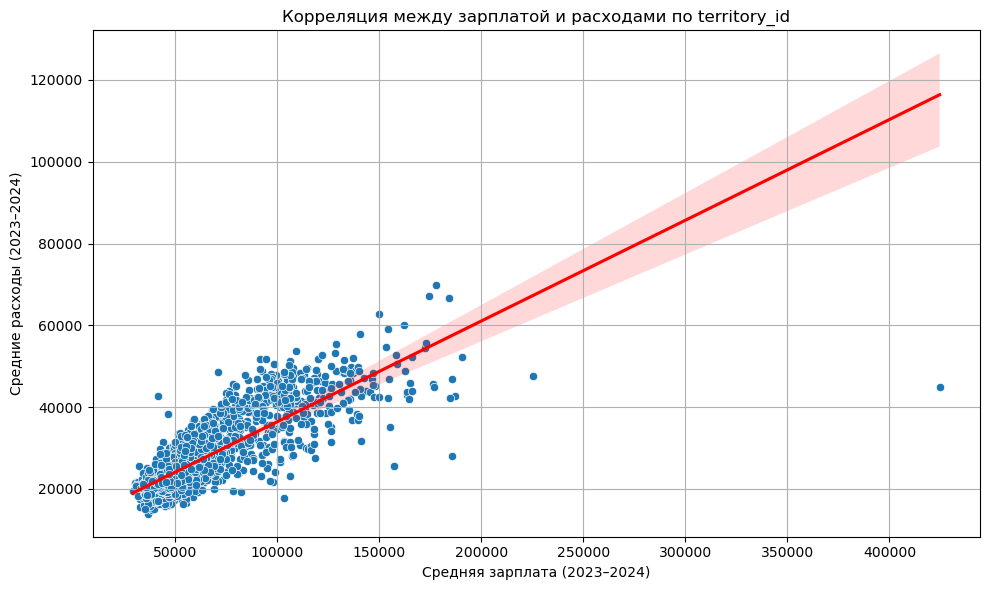

Коэффициент корреляции: 0.82


In [16]:
# Выявим корреляцию между зарплатой и расходами
plt.figure(figsize=(10, 6))
sns.scatterplot(
    data=gdf_md_with_salary_and_consumption,
    x='mean_salary_for_2023_2024',
    y='mean_spending_for_2023_2024'
)

sns.regplot(
    data=gdf_md_with_salary_and_consumption,
    x='mean_salary_for_2023_2024',
    y='mean_spending_for_2023_2024',
    
    scatter=False,
    color='red'
)

plt.title("Корреляция между зарплатой и расходами по territory_id")
plt.xlabel("Средняя зарплата (2023–2024)")
plt.ylabel("Средние расходы (2023–2024)")
plt.grid(True)
plt.tight_layout()
plt.show()

# Вычисление коэффициента корреляции
correlation = gdf_md_with_salary_and_consumption['mean_salary_for_2023_2024'].corr(gdf_md_with_salary_and_consumption['mean_spending_for_2023_2024'])
print(f"Коэффициент корреляции: {correlation:.2f}")


In [34]:
# Выявим выбросы по линейной регрессии

# Возьмем только нужные колонки
X = gdf_md_with_salary_and_consumption['mean_salary_for_2023_2024']
y = gdf_md_with_salary_and_consumption['mean_spending_for_2023_2024']

# Добавим константу для регрессии
X_const = sm.add_constant(X)
model = sm.OLS(y, X_const).fit()

# Предсказанные значения
gdf_md_with_salary_and_consumption['predicted_spending'] = model.predict(X_const)

# Отклонение от линии тренда
gdf_md_with_salary_and_consumption['residual'] = gdf_md_with_salary_and_consumption['mean_spending_for_2023_2024'] - gdf_md_with_salary_and_consumption['predicted_spending']

# Абсолютное значение отклонения — насколько сильно "выпадает" из тренда
gdf_md_with_salary_and_consumption['abs_residual'] = gdf_md_with_salary_and_consumption['residual'].abs()

# Найдём записи с наибольшими отклонениями
gdf_top10_salary_and_consumption_correlation_difference = gdf_md_with_salary_and_consumption.sort_values(by='abs_residual', ascending=False).head(10)
gdf_top10_salary_and_consumption_correlation_difference.to_file("top10_salary_and_consumption_correlation_difference.gpkg")
gdf_top10_salary_and_consumption_correlation_difference

,geometry,territory_id,municipal_district_name_short,municipal_district_name,region_name,mean_salary_for_2023_2024,mean_spending_for_2023_2024,predicted_spending,residual,abs_residual,abs_salary_difference
1926,"MULTIPOLYGON (((30.17854 59.9903, 30.17862 59....",2371,Лахта-Ольгино,внутригородская территория города федерального...,Санкт-Петербург,424601.3500,45003.625000,116393.122075,-71389.497075,71389.497075,379597.725000
1230,"MULTIPOLYGON (((127.17419 50.90317, 127.17398 ...",883,Свободненский,Свободненский муниципальный район,Амурская область,185512.9625,27919.416667,57498.916879,-29579.500212,29579.500212,157593.545833
158,"MULTIPOLYGON (((48.46196 55.51213, 48.46144 55...",370,Верхнеуслонский,Верхнеуслонский муниципальный район,Республика Татарстан,157211.0625,25563.541667,50527.361616,-24963.819950,24963.819950,131647.520833
1793,"MULTIPOLYGON (((37.18677 56.23994, 37.18967 56...",3013,Солнечногорск,городской округ Солнечногорск,Московская область,41369.8750,42617.083333,21992.413775,20624.669558,20624.669558,1247.208333
1208,"MULTIPOLYGON (((155.67607 53.51291, 155.67446 ...",614,Соболевский,Соболевский муниципальный район,Камчатский край,225355.1375,47499.500000,67313.166975,-19813.666975,19813.666975,177855.637500
1536,"MULTIPOLYGON (((48.2447 46.43985, 48.24477 46....",925,Красноярский,Красноярский муниципальный район,Астраханская область,103423.9875,17802.583333,37278.089809,-19475.506476,19475.506476,85621.404167
1944,"MULTIPOLYGON (((30.3115 59.73116, 30.31608 59....",2448,Александровская,внутригородская территория города федерального...,Санкт-Петербург,70969.6500,48580.000000,29283.672212,19296.327788,19296.327788,22389.650000
1795,"MULTIPOLYGON (((37.24578 55.88165, 37.2456 55....",3008,Химки,городской округ Химки,Московская область,91236.2500,51795.666667,34275.906722,17519.759944,17519.759944,39440.583333
1965,"MULTIPOLYGON (((30.27379 59.96504, 30.27414 59...",2443,Петровский,внутригородская территория города федерального...,Санкт-Петербург,94219.4000,51708.833333,35010.740606,16698.092728,16698.092728,42510.566667
1972,"MULTIPOLYGON (((30.17563 59.87035, 30.1762 59....",2405,Южно-Приморский,внутригородская территория города федерального...,Санкт-Петербург,84246.9250,47781.958333,32554.239079,15227.719255,15227.719255,36464.966667


In [35]:
# Определим также наибольшие чистые отклонения
gdf_md_with_salary_and_consumption["abs_salary_difference"] = abs(gdf_md_with_salary_and_consumption["mean_salary_for_2023_2024"] - gdf_md_with_salary_and_consumption["mean_spending_for_2023_2024"])
gdf_top10_abs_salary_and_consumption_difference = gdf_md_with_salary_and_consumption.sort_values("abs_salary_difference", ascending=False).iloc[0:10].copy()
gdf_top10_abs_salary_and_consumption_difference.to_file("top10_abs_salary_and_consumption_difference.gpkg")
gdf_top10_abs_salary_and_consumption_difference

,geometry,territory_id,municipal_district_name_short,municipal_district_name,region_name,mean_salary_for_2023_2024,mean_spending_for_2023_2024,predicted_spending,residual,abs_residual,abs_salary_difference
1926,"MULTIPOLYGON (((30.17854 59.9903, 30.17862 59....",2371,Лахта-Ольгино,внутригородская территория города федерального...,Санкт-Петербург,424601.3500,45003.625000,116393.122075,-71389.497075,71389.497075,379597.725000
1208,"MULTIPOLYGON (((155.67607 53.51291, 155.67446 ...",614,Соболевский,Соболевский муниципальный район,Камчатский край,225355.1375,47499.500000,67313.166975,-19813.666975,19813.666975,177855.637500
1230,"MULTIPOLYGON (((127.17419 50.90317, 127.17398 ...",883,Свободненский,Свободненский муниципальный район,Амурская область,185512.9625,27919.416667,57498.916879,-29579.500212,29579.500212,157593.545833
760,"MULTIPOLYGON (((73.81158 68.81706, 73.79371 68...",2245,Надымский,муниципальный округ Надымский район,Ямало-Ненецкий автономный округ,186965.6750,42693.916667,57856.760892,-15162.844225,15162.844225,144271.758333
1987,"MULTIPOLYGON (((30.03864 59.82172, 30.03859 59...",2446,Стрельна,внутригородская территория города федерального...,Санкт-Петербург,184432.9750,42314.666667,57232.885533,-14918.218867,14918.218867,142118.308333
1203,"MULTIPOLYGON (((157.5178 61.49651, 157.2362 61...",1432,Омсукчанский,муниципальный округ Омсукчанский,Магаданская область,185367.8625,46843.812500,57463.174661,-10619.362161,10619.362161,138524.050000
1211,"MULTIPOLYGON (((174.50239 61.6078, 174.47817 6...",619,Олюторский,Олюторский муниципальный район,Камчатский край,190453.5000,52275.125000,58715.910445,-6440.785445,6440.785445,138178.375000
1202,"MULTIPOLYGON (((157.5178 61.49651, 157.43003 6...",1433,Северо-Эвенский,муниципальный округ Северо-Эвенский,Магаданская область,176897.5250,44985.000000,55376.691917,-10391.691917,10391.691917,131912.525000
158,"MULTIPOLYGON (((48.46196 55.51213, 48.46144 55...",370,Верхнеуслонский,Верхнеуслонский муниципальный район,Республика Татарстан,157211.0625,25563.541667,50527.361616,-24963.819950,24963.819950,131647.520833
1119,"MULTIPOLYGON (((142.4096 51.79596, 142.41101 5...",1961,Ногликский,городской округ Ногликский,Сахалинская область,176429.4250,45708.458333,55261.385700,-9552.927367,9552.927367,130720.966667
